# ARIMA Model - 2

---

#### Imports

In [1]:
# Standard Imports
import pandas as pd
import matplotlib.pyplot as plt

# ARIMA Imports
from pmdarima import auto_arima, ARIMA
from pmdarima.model_selection import RollingForecastCV, cross_val_score

from statsmodels.graphics.tsaplots import plot_acf

from forecast_tools.metrics import (mean_absolute_error,
                                    winkler_score)

import ts_utils

#### Loading and Splitting Data

In [2]:
# Load in the dataset and frequency is set to daily
paeds_ed_appointments = pd.read_csv('paediatrics_train.csv',
                                    index_col='date',
                                    parse_dates=True)

paeds_ed_appointments.index.freq = 'D'

In [3]:
# Train-test split: Training (all but the last 28 days)
# and testing (the last 28 days)
train = paeds_ed_appointments["paed_ed_attends"].iloc[:-28]
test = paeds_ed_appointments["paed_ed_attends"].iloc[-28:]

#### Autocorrelation

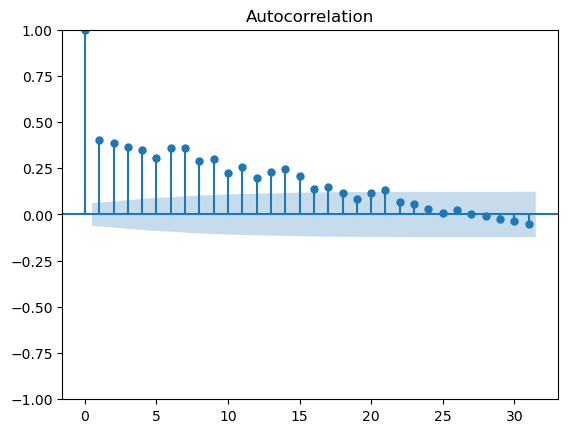

In [4]:
# Plotting autocorrelation function (ACF)
plot_acf(train);

---

#### **Option 1 Auto ARIMA:**
- **ARIMA (p, d, q):** Automatically generated

- **Seasonal ARIMA (P, D, Q, s):** Automatically generated



In [5]:
# Model 1: Automatic ARIMA with default parameters
auto_model = auto_arima(train, m=7, suppress_warnings=True)
auto_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       SARIMAX Results                                        
==============================================================================================
Dep. Variable:                                      y   No. Observations:                 1028
Model:             SARIMAX(0, 1, 1)x(0, 0, [1, 2], 7)   Log Likelihood               -3602.332
Date:                                Tue, 18 Feb 2025   AIC                           7212.664
Time:                                        18:22:26   BIC                           7232.402
Sample:                                    04-01-2014   HQIC                          7220.156
                                         - 01-22-2017                                         
Covariance Type:                                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8043      0.018    -44.133      0.000      -0.840      -0.769
ma.S.L7        0.0689      0.031      2.236      0.025       0.009       0.129
ma.S.L14       0.0677      0.030      2.235      0.025       0.008       0.127
sigma2        65.1248      2.902     22.438      0.000      59.436      70.813
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 0.79
Prob(Q):                              0.99   Prob(JB):                         0.67
Heteroskedasticity (H):               1.04   Skew:                             0.07
Prob(H) (two-sided):                  0.74   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [6]:
# Evaluate MAE in order to select which model to use for CV
pred_auto_arima = auto_model.predict(n_periods=28)

auto_arima_mae = mean_absolute_error(y_true=test,
                                     y_pred=pred_auto_arima)

print(f"Auto ARIMA Model 1: {auto_model.order}, {auto_model.seasonal_order}"
      f" MAE: {auto_arima_mae:.2f}, AIC: {auto_model.aic():.2f}.")

Auto ARIMA Model 1: (0, 1, 1), (0, 0, 2, 7) MAE: 7.31, AIC: 7212.66.


---

#### **Option 2 Model Parameters:**
- **ARIMA (p, d, q):** (1, 1, 0)  
  - `p=1`: Includes one autoregressive term  
  - `d=1`: First-order differencing to remove trend  
  - `q=0`: No moving average (MA) terms included

- **Seasonal ARIMA (P, D, Q, s):** (1, 0, 0, 7)  
  - `P=1`: One seasonal autoregressive (SAR) term 
  - `D=0`: No seasonal differencing (data is already stationary seasonally)  
  - `Q=0`: No seasonal moving average (SMA) terms
  - `s=7`: Weekly seasonality

In [7]:
# Model 2: Manual ARIMA investigation
manual_model_2 = ARIMA(order=(1, 1, 0),
                       seasonal_order=(1, 0, 0, 7),
                       suppress_warnings=True)

manual_model_2.fit(train)

manual_model_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                 1028
Model:             SARIMAX(1, 1, 0)x(1, 0, 0, 7)   Log Likelihood               -3715.244
Date:                           Tue, 18 Feb 2025   AIC                           7438.487
Time:                                   18:22:27   BIC                           7458.225
Sample:                               04-01-2014   HQIC                          7445.979
                                    - 01-22-2017                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0014      0.282      0.005      0.996      -0.550       0.553
ar.L1         -0.4928      0.028    -17.663      0.000      -0.547      -0.438
ar.S.L7        0.0853      0.031      2.786      0.005       0.025       0.145
sigma2        81.2018      3.684     22.041      0.000      73.981      88.422
===================================================================================
Ljung-Box (L1) (Q):                  23.23   Jarque-Bera (JB):                 0.58
Prob(Q):                              0.00   Prob(JB):                         0.75
Heteroskedasticity (H):               1.01   Skew:                            -0.03
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [8]:
# Evaluate MAE in order to select which model for CV
pred_model_2 = manual_model_2.predict(n_periods=28)

pred_model_2_mae = mean_absolute_error(y_true=test,
                                       y_pred=pred_model_2)

print(f"Manual ARIMA Model 1: {manual_model_2.order}, "
      f"{manual_model_2.seasonal_order} MAE: {pred_model_2_mae:.2f},"
      f" AIC: {manual_model_2.aic():.2f}.")

Manual ARIMA Model 1: (1, 1, 0), (1, 0, 0, 7) MAE: 7.32, AIC: 7438.49.


---

#### **Option 3 Model Parameters:**
- **ARIMA (p, d, q):** (1, 1, 0)  
  - `p=1`: One autoregressive term to account for past values  
  - `d=1`: First-order differencing to remove trend and ensure stationarity  
  - `q=0`: No moving average (MA) terms included  

- **Seasonal ARIMA (P, D, Q, s):** (0, 0, 0, 7)  
  - `P=0`: No seasonal autoregressive terms included
  - `D=0`: No seasonal differencing
  - `Q=0`: No seasonal moving average terms  
  - `s=7`: Assumes a seasonal pattern repeats every 7 time steps


In [9]:
# Model 3: Manual Model further investigation
manual_model_3 = ARIMA(order=(1, 1, 0),
                       seasonal_order=(0, 0, 0, 7),
                       suppress_warnings=True)

manual_model_3.fit(train)

manual_model_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1028
Model:               SARIMAX(1, 1, 0)   Log Likelihood               -3718.984
Date:                Tue, 18 Feb 2025   AIC                           7443.969
Time:                        18:22:27   BIC                           7458.772
Sample:                    04-01-2014   HQIC                          7449.588
                         - 01-22-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0021      0.282      0.008      0.994      -0.551       0.556
ar.L1         -0.4899      0.028    -17.505      0.000      -0.545      -0.435
sigma2        81.7997      3.704     22.084      0.000      74.540      89.059
===================================================================================
Ljung-Box (L1) (Q):                  22.48   Jarque-Bera (JB):                 0.65
Prob(Q):                              0.00   Prob(JB):                         0.72
Heteroskedasticity (H):               1.01   Skew:                            -0.04
Prob(H) (two-sided):                  0.93   Kurtosis:                         2.91
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [10]:
# Evaluate MAE in order to select which model for CV
pred_model_3 = manual_model_3.predict(n_periods=28)

pred_model_3_mae = mean_absolute_error(y_true=test,
                                       y_pred=pred_model_3)

print(f"Manual ARIMA Model 2: {manual_model_3.order}, "
      f"{manual_model_3.seasonal_order} MAE: {pred_model_3_mae:.2f},"
      f" AIC: {manual_model_3.aic():.2f}.")

Manual ARIMA Model 2: (1, 1, 0), (0, 0, 0, 7) MAE: 7.27, AIC: 7443.97.


---

#### Generating Forecasts and Prediction Intervals for all 3 models

In [11]:
# Predict the next 28 days of paediatric ED attendances using each model
preds_1, intervals_1 = auto_model.predict(
    n_periods=28,
    return_conf_int=True
)

preds_2, intervals_2 = manual_model_2.predict(
    n_periods=28,
    return_conf_int=True
)

preds_3, intervals_3 = manual_model_3.predict(
    n_periods=28,
    return_conf_int=True
)

# Convert predictions to DataFrames for all three models
pred_1_df, intervals_1_df = ts_utils.arima_preds_to_dataframe(
    y_train=train,
    preds=preds_1,
    intervals=intervals_1
)

pred_2_df, intervals_2_df = ts_utils.arima_preds_to_dataframe(
    y_train=train,
    preds=preds_2,
    intervals=intervals_2
)

pred_3_df, intervals_3_df = ts_utils.arima_preds_to_dataframe(
    y_train=train,
    preds=preds_3,
    intervals=intervals_3
)

---

#### Plotting Best Performing Single Run Model - Auto ARIMA

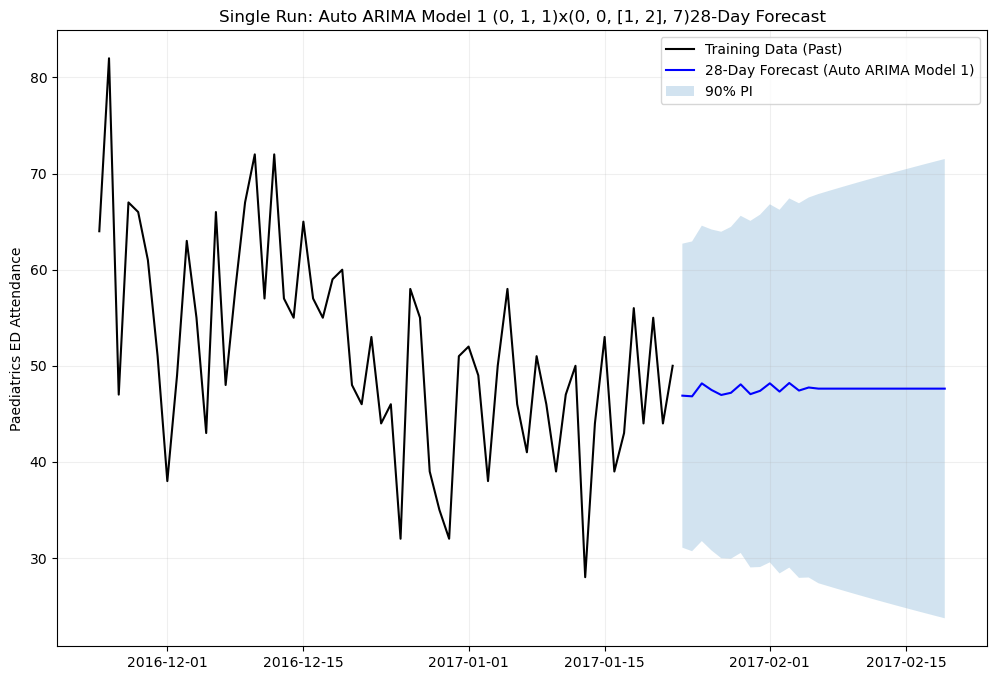

In [12]:
# Plot the 28-day forecast with 90% prediction intervals
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train[-60:], label="Training Data (Past)", color='black')

ax.plot(pred_1_df, label="28-Day Forecast (Auto ARIMA Model 1)", color='blue')

ax.fill_between(intervals_1_df.index,
                intervals_1_df['lower'],
                intervals_1_df['upper'],
                alpha=0.2,
                label='90% PI')

ax.set_title("Single Run: Auto ARIMA Model 1 (0, 1, 1)x(0, 0, [1, 2], 7)"
             "28-Day Forecast")

ax.set_ylabel('Paediatrics ED Attendance')
plt.grid(True, alpha=0.2)
ax.legend()

plt.show()

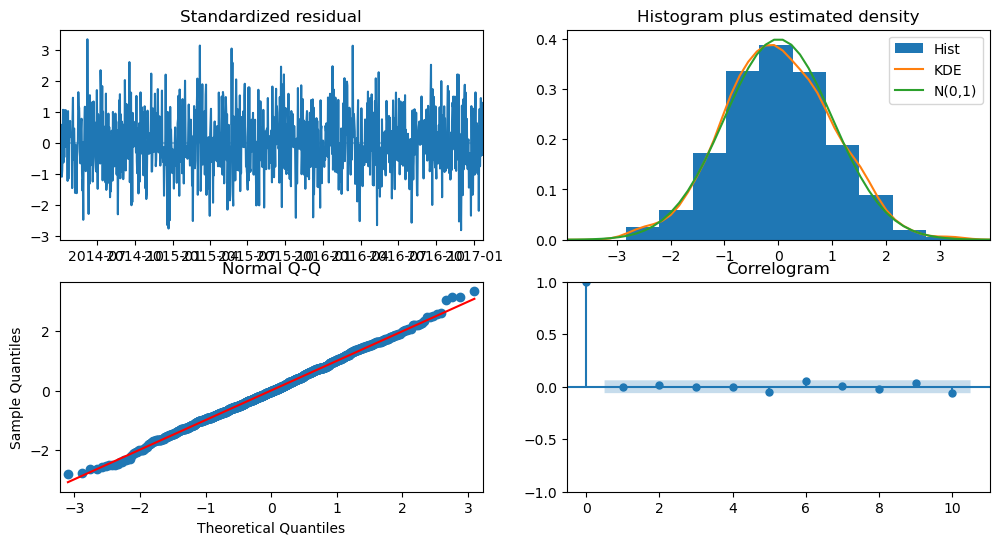

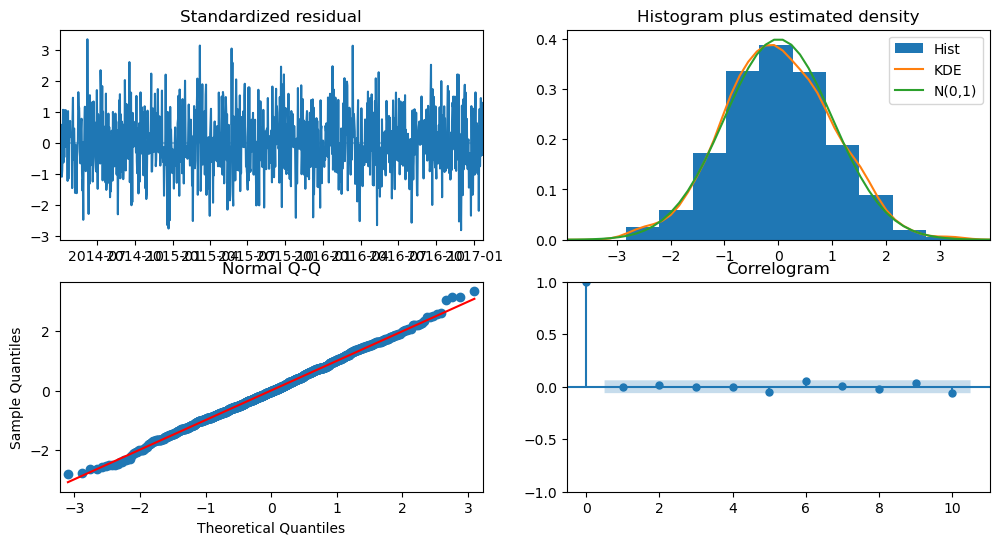

In [13]:
# Plot diagnostics for auto ARIMA
auto_model.plot_diagnostics(figsize=(12, 6))

# Cross Validation for ARIMA Models

In [14]:
# Cross-Validation for ARIMA Models
cv = RollingForecastCV(h=28, step=28, initial=len(train) // 3)

In [15]:
# Use cross_val_score to evaluate MAE for each model using CV
scores_1_mae = cross_val_score(auto_model,
                               train,
                               cv=cv,
                               scoring='mean_absolute_error',
                               verbose=0)

scores_2_mae = cross_val_score(manual_model_2,
                               train,
                               cv=cv,
                               scoring='mean_absolute_error',
                               verbose=0)

scores_3_mae = cross_val_score(manual_model_3,
                               train,
                               cv=cv,
                               scoring='mean_absolute_error',
                               verbose=0)

# Print out MAE for each model
print(f"CV Auto ARIMA Model 1: {auto_model.order}, {auto_model.seasonal_order}"
      f" MAE: {scores_1_mae.mean():.2f}, AIC: {auto_model.aic():.2f}.")

print(f"CV Manual ARIMA Model 2: {manual_model_2.order},"
      f" {manual_model_2.seasonal_order} MAE: {scores_2_mae.mean():.2f},"
      f" AIC: {manual_model_2.aic():.2f}.")

print(f"CV Manual ARIMA Model 3: {manual_model_3.order},"
      f" {manual_model_3.seasonal_order} MAE: {scores_3_mae.mean():.2f},"
      f" AIC: {manual_model_3.aic():.2f}.")

CV Auto ARIMA Model 1: (0, 1, 1), (0, 0, 2, 7) MAE: 7.78, AIC: 7212.66.
CV Manual ARIMA Model 2: (1, 1, 0), (1, 0, 0, 7) MAE: 8.89, AIC: 7438.49.
CV Manual ARIMA Model 3: (1, 1, 0), (0, 0, 0, 7) MAE: 8.79, AIC: 7443.97.


#### Final Model Selction

In [16]:
# Final model: Model 1 (best performing) - Auto ARIMA
model_best = auto_model

In [17]:
# Get predictions for the best model (90% and 80% intervals)
preds_best, intervals_90 = model_best.predict(
    n_periods=28,
    return_conf_int=True,
    alpha=0.1
)

preds_best, intervals_80 = model_best.predict(
    n_periods=28,
    return_conf_int=True,
    alpha=0.2
)

# Get predictions for Manual 1 model (90% and 80% intervals)
preds_best_man_1, intervals_90_man_1 = manual_model_2.predict(
    n_periods=28,
    return_conf_int=True,
    alpha=0.1
)

preds_best_man_1, intervals_80_man_1 = manual_model_2.predict(
    n_periods=28,
    return_conf_int=True,
    alpha=0.2
)

# Get predictions for Manual 2 model (90% and 80% intervals)
preds_best_man_2, intervals_90_man_2 = manual_model_3.predict(
    n_periods=28,
    return_conf_int=True,
    alpha=0.1
)

preds_best_man_2, intervals_80_man_2 = manual_model_3.predict(
    n_periods=28,
    return_conf_int=True,
    alpha=0.2
)

In [18]:
# Now generating the Winkler Score for each model
auto_arima_winkler_90 = winkler_score(
    intervals=intervals_90,
    observations=pd.DataFrame(test),
    alpha=0.1
)

auto_arima_winkler_80 = winkler_score(
    intervals=intervals_80,
    observations=pd.DataFrame(test),
    alpha=0.2
)

manual_model_2_winkler_90 = winkler_score(
    intervals=intervals_90_man_1,
    observations=pd.DataFrame(test),
    alpha=0.1
)

manual_model_2_winkler_80 = winkler_score(
    intervals=intervals_80_man_1,
    observations=pd.DataFrame(test),
    alpha=0.2
)

manual_model_3_winkler_90 = winkler_score(
    intervals=intervals_90_man_2,
    observations=pd.DataFrame(test),
    alpha=0.1
)

manual_model_3_winkler_80 = winkler_score(
    intervals=intervals_80_man_2,
    observations=pd.DataFrame(test),
    alpha=0.2
)

In [19]:
print(f"Auto ARIMA(0, 1, 1), (0, 0, 2, 7) Winkler Score for 80% PI:"
      f" {auto_arima_winkler_80:.2f}")

print(f"Auto ARIMA (0, 1, 1), (0, 0, 2, 7) Winkler Score for 90% PI:"
      f" {auto_arima_winkler_90:.2f}\n")

print(f"ARIMA (1, 1, 0), (1, 0, 0, 7) Winkler Score for 80% PI:"
      f" {manual_model_2_winkler_80:.2f}")

print(f"ARIMA (1, 1, 0), (1, 0, 0, 7) Winkler Score for 90% PI:"
      f" {manual_model_2_winkler_90:.2f}\n")

print(f"ARIMA (1, 1, 0), (0, 0, 0, 7) Winkler Score for 80% PI:"
      f" {manual_model_3_winkler_80:.2f}")

print(f"ARIMA (1, 1, 0), (0, 0, 0, 7) Winkler Score for 90% PI:"
      f" {manual_model_3_winkler_90:.2f}")

Auto ARIMA(0, 1, 1), (0, 0, 2, 7) Winkler Score for 80% PI: 35.03
Auto ARIMA (0, 1, 1), (0, 0, 2, 7) Winkler Score for 90% PI: 38.36

ARIMA (1, 1, 0), (1, 0, 0, 7) Winkler Score for 80% PI: 60.91
ARIMA (1, 1, 0), (1, 0, 0, 7) Winkler Score for 90% PI: 78.18

ARIMA (1, 1, 0), (0, 0, 0, 7) Winkler Score for 80% PI: 58.65
ARIMA (1, 1, 0), (0, 0, 0, 7) Winkler Score for 90% PI: 75.27


In [20]:
# Convert to DataFrames for easier plotting of Auto ARIMA
preds_best_df, intervals_best_90_df = ts_utils.arima_preds_to_dataframe(
    y_train=train, preds=preds_best, intervals=intervals_90
)

preds_best_80_df, intervals_best_80_df = ts_utils.arima_preds_to_dataframe(
    y_train=train, preds=preds_best, intervals=intervals_80
)

#### Plotting 28 Day Forecasts for Best Performing Model with PI's

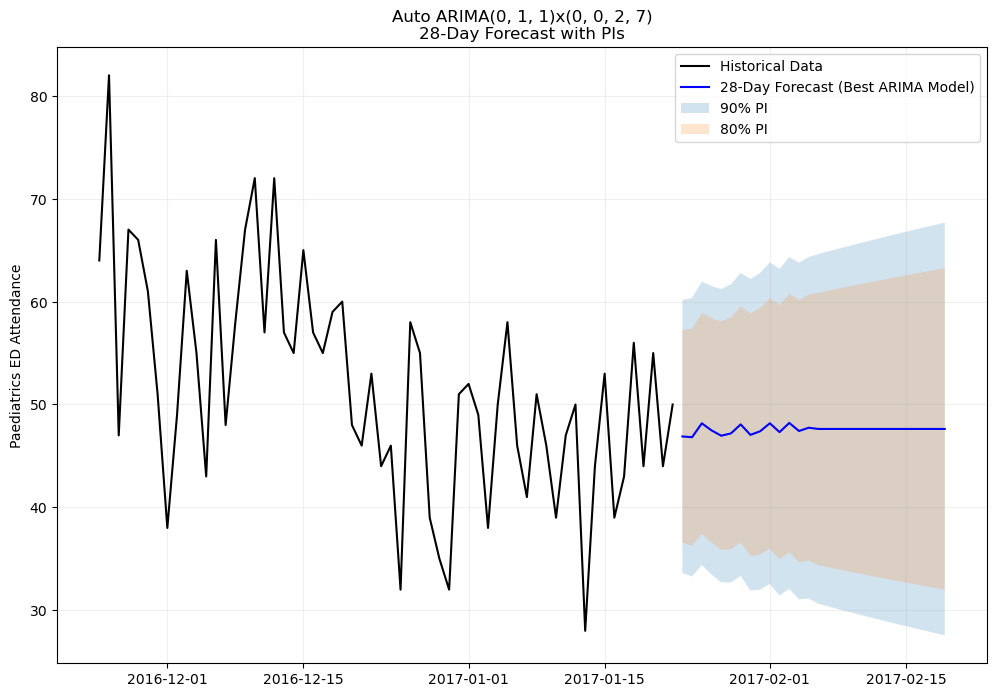

In [21]:
# Plot (Model 1-Auto ARIMA) 28-day forecast with 90% and 80% PIs
fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(train[-60:], label="Historical Data", color='black')

ax.plot(preds_best_df,
        label="28-Day Forecast (Best ARIMA Model)",
        color='blue')

ax.fill_between(
        intervals_best_90_df.index,
        intervals_best_90_df['lower'],
        intervals_best_90_df['upper'],
        alpha=0.2,
        label='90% PI'
)

ax.fill_between(
        intervals_best_80_df.index,
        intervals_best_80_df['lower'],
        intervals_best_80_df['upper'],
        alpha=0.2,
        label='80% PI'
)

ax.set_title(
    "Auto ARIMA(0, 1, 1)x(0, 0, 2, 7)\n"
    "28-Day Forecast with PIs"
)
ax.set_ylabel('Paediatrics ED Attendance')
ax.legend()
plt.grid(True, alpha=0.2)

plt.show()

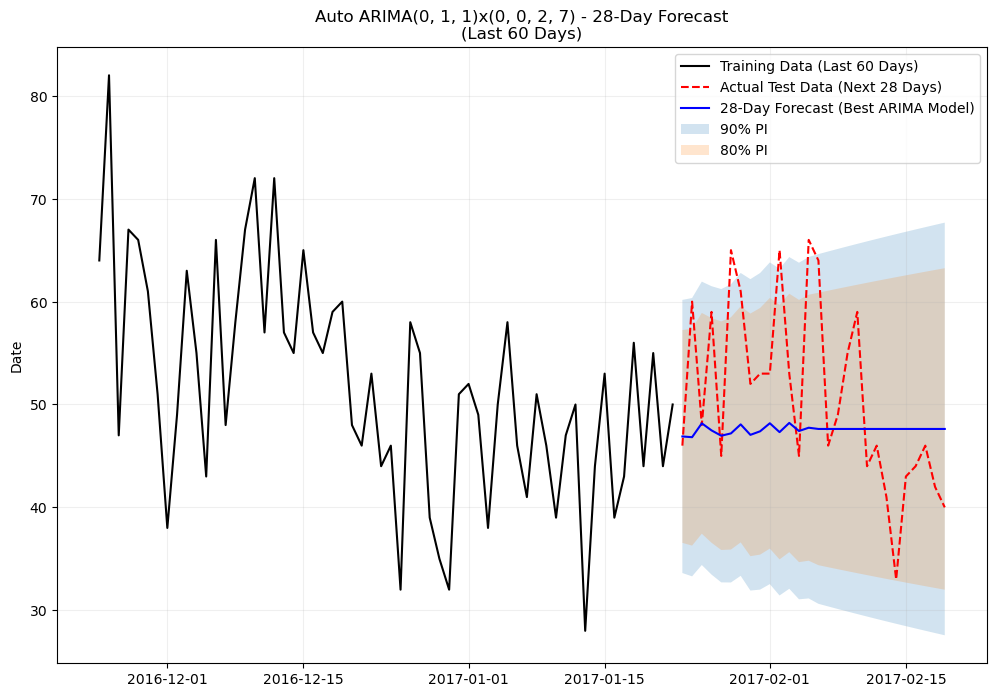

In [22]:
# Plot 28-day forecast with 80% and 90% prediction intervals
# Zoomed into the last 60 days of training data
fig, ax = plt.subplots(figsize=(12, 8))

# Plot the last 60 days of training data
ax.plot(train[-60:], label="Training Data (Last 60 Days)",
        color='black')

ax.plot(test[-28:], label="Actual Test Data (Next 28 Days)",
        color='red',
        linestyle='dashed')

# Plot the 28-day forecast for the next 28 days from the best ARIMA model
ax.plot(preds_best_df[-28:],
        label="28-Day Forecast (Best ARIMA Model)",
        color='blue')

# Fill prediction intervals for 90% and 80% for the last 28 days of forecast
ax.fill_between(
        intervals_best_90_df.index[-28:],
        intervals_best_90_df['lower'][-28:],
        intervals_best_90_df['upper'][-28:],
        alpha=0.2,
        label='90% PI'
)

ax.fill_between(
        intervals_best_80_df.index[-28:],
        intervals_best_80_df['lower'][-28:],
        intervals_best_80_df['upper'][-28:],
        alpha=0.2,
        label='80% PI'
)

ax.set_title(
        "Auto ARIMA(0, 1, 1)x(0, 0, 2, 7) - 28-Day Forecast\n"
        "(Last 60 Days)"
)
ax.set_ylabel('Paediatrics ED Attendance')
ax.set_ylabel('Date')
ax.legend()
plt.grid(True, alpha=0.2)

plt.show()

#### Save Predictions to a CSV

In [23]:
type(preds_best_df)

pandas.core.frame.DataFrame

In [24]:
# Folder where the CSV will be saved
output_folder = "model_predictions"  

# Convert predictions to DataFrame (a copy)
forecast_df_arima = preds_best_df.copy()

# Reset index to include the "Date" column
forecast_df_arima = forecast_df_arima.reset_index()

# Rename columns
forecast_df_arima.columns = ["Date", "ARIMA_Forecast"]

# Add Prediction Intervals
forecast_df_arima["Lower_80_PI"] = intervals_best_80_df["lower"].values
forecast_df_arima["Upper_80_PI"] = intervals_best_80_df["upper"].values
forecast_df_arima["Lower_90_PI"] = intervals_best_90_df["lower"].values
forecast_df_arima["Upper_90_PI"] = intervals_best_90_df["upper"].values

# Save to CSV inside "model_predictions" folder
forecast_path_arima = f"{output_folder}/auto_arima_forecast.csv"
forecast_df_arima.to_csv(forecast_path_arima, index=False)

print(f"Auto ARIMA forecast saved to {forecast_path_arima}")
print(forecast_df_arima.head())

Auto ARIMA forecast saved to model_predictions/auto_arima_forecast.csv
        Date  ARIMA_Forecast  Lower_80_PI  Upper_80_PI  Lower_90_PI  \
0 2017-01-23       46.891474    36.549365    57.233584    33.617520   
1 2017-01-24       46.821529    36.283139    57.359918    33.295652   
2 2017-01-25       48.169611    37.438531    58.900690    34.396419   
3 2017-01-26       47.482097    36.561727    58.402468    33.465954   
4 2017-01-27       46.963826    35.857390    58.070261    32.708870   

   Upper_90_PI  
0    60.165428  
1    60.347405  
2    61.942802  
3    61.498241  
4    61.218781  


*Page 4*